In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go



In [2]:
import cv2 as cv

In [5]:
image_path = 'C:/Shanta/data/images/0/000000 (6).png'

In [6]:
image = cv.imread(image_path)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image.shape

(264, 409, 3)

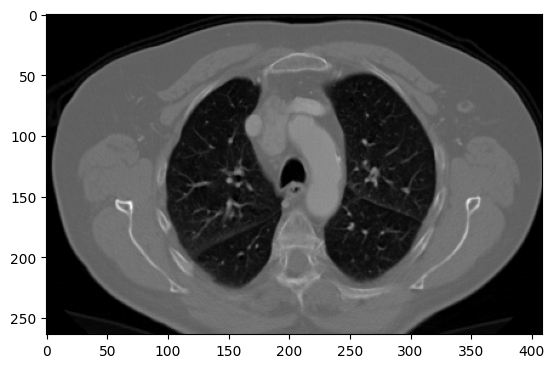

In [7]:
plt.imshow(image)

In [8]:
if image.dtype == bool:
    image = image.astype('uint8')

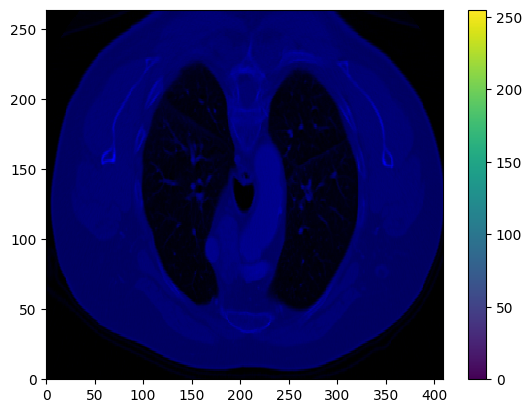

In [9]:
hsv=  cv.cvtColor(image, cv.COLOR_RGB2HSV)
plt.pcolormesh(hsv)
plt.colorbar()

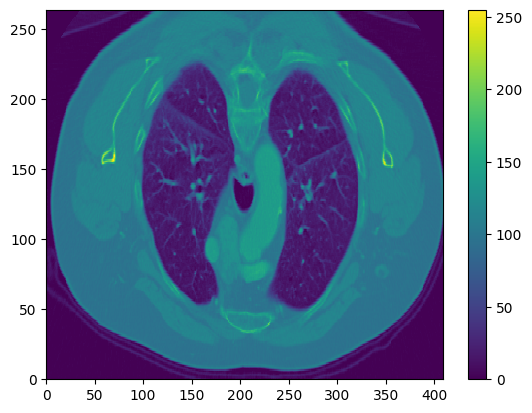

In [10]:
gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
plt.pcolormesh(gray)
plt.colorbar()

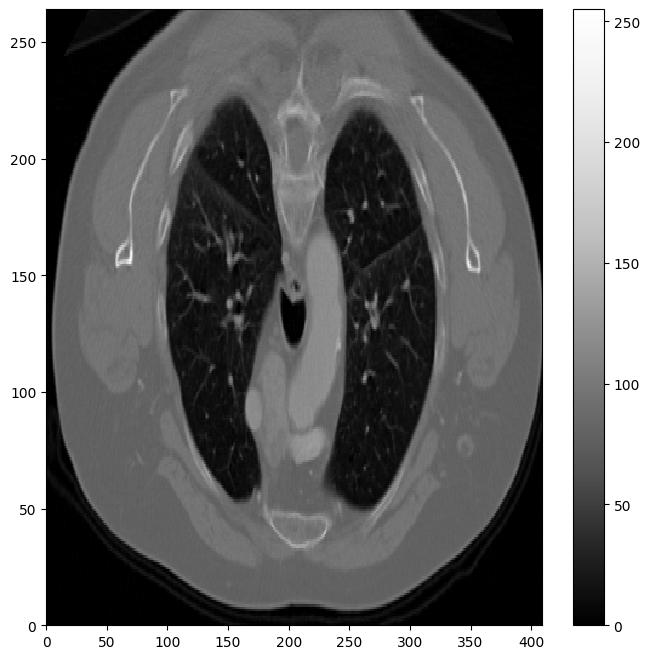

In [11]:
plt.figure(figsize=(8,8))
plt.pcolormesh(image, cmap='Greys_r')
plt.colorbar()

In [12]:
np.max(image)

255

In [13]:
gray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [14]:
mask = gray < 50

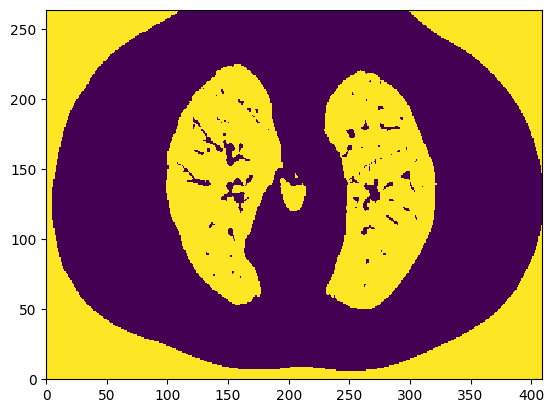

In [15]:
plt.pcolormesh(mask)

In [16]:
mask.shape

(264, 409)

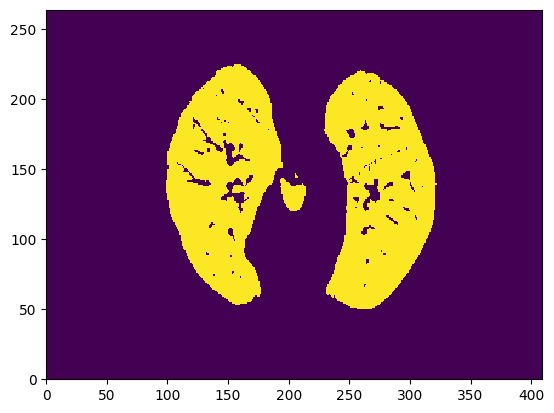

In [17]:
mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask)

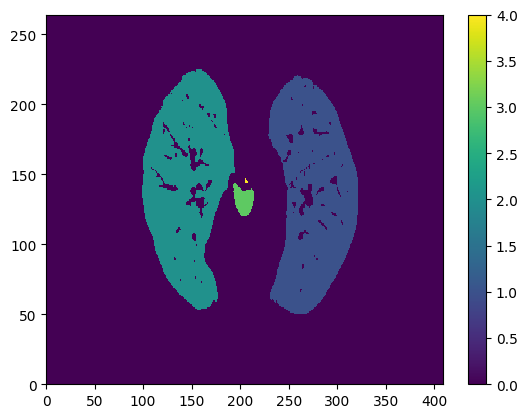

In [18]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask_labeled)
plt.colorbar()

In [19]:
slc = mask_labeled
rps = regionprops(slc)
areas = [r.area for r in rps]
areas
np.argsort(areas)[::-1]

array([0, 1, 2, 3], dtype=int64)

In [20]:
slc = mask_labeled
rps = regionprops(slc)
areas = [r.area for r in rps]
idxs = np.argsort(areas)[::-1]

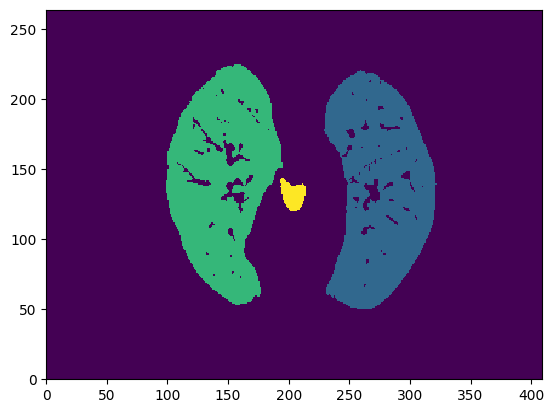

In [21]:
new_slc = np.zeros_like(slc)
new_slc = np.zeros_like(slc)
for i in idxs[:3]:
    new_slc[tuple(rps[i].coords.T)] = i+1


plt.pcolormesh(new_slc)

In [22]:
def keep_top_3(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    for i in idxs[:3]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

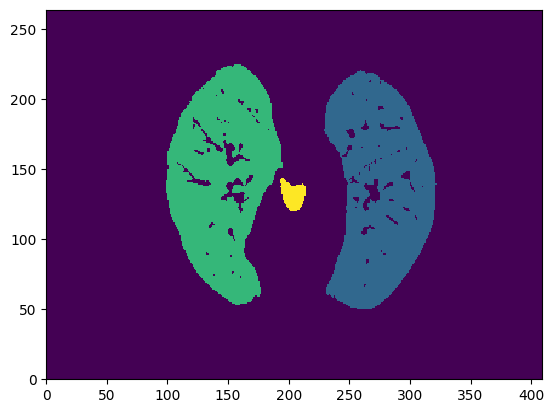

In [23]:
mask_labeled = np.vectorize(keep_top_3, signature='(n,m)->(n,m)')(mask_labeled)
plt.pcolormesh(mask_labeled)

In [24]:
def remove_trachea(slc, c=0.0069):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/512**2 < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

In [25]:
mask = np.vectorize(remove_trachea, signature='(n,m)->(n,m)')(mask)

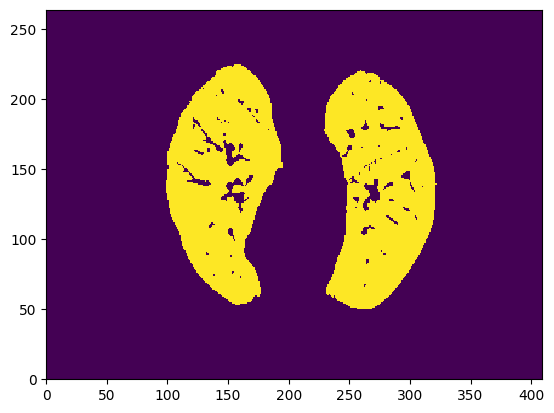

In [26]:
plt.pcolormesh(mask)

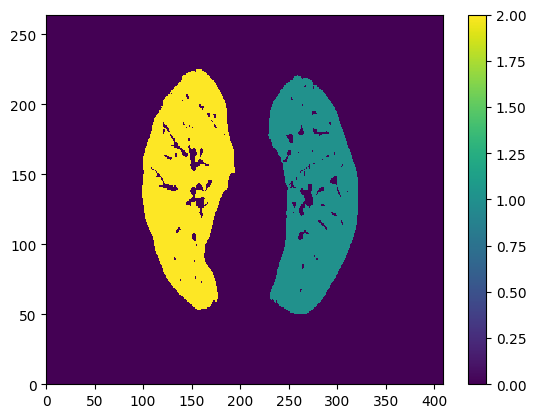

In [27]:
labels = label(mask, background=0)
plt.pcolormesh(labels)
plt.colorbar()

In [28]:
center_of_mass(labels==2)[0]

143.10135922330096

In [29]:
def delete_table(slc):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < 0.3*slc.shape[0]):
            new_slc[labels==idx] = 0
        elif (COM_y > 0.6*slc.shape[0]):
            new_slc[labels==idx] = 0
    return new_slc

In [30]:
mask_new = np.vectorize(delete_table, signature='(n,m)->(n,m)')(mask)

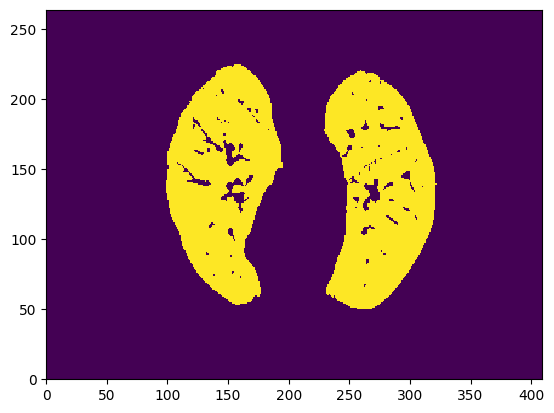

In [31]:
plt.pcolormesh(mask_new)

In [32]:
mask_new = binary_dilation(mask_new, iterations=5)

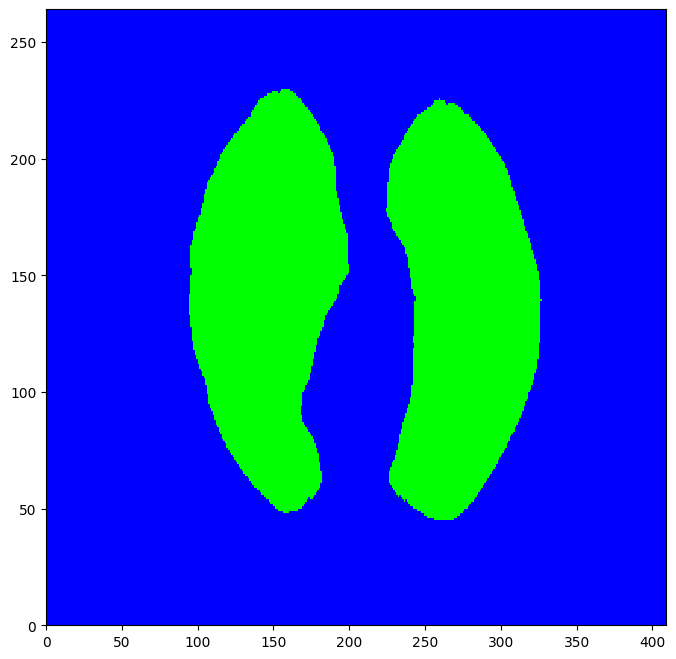

In [33]:
plt.figure(figsize=(8,8))
plt.pcolormesh(mask_new, cmap='brg')

In [34]:
mask_new.shape

(264, 409)

In [35]:
im = zoom(1*(image), (0.4,0.4,0.4))
z, y, x = [np.arange(i) for i in im.shape]
z*=4
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=np.transpose(im,(1,2,0)).flatten(),
    isomin=0.1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.write_html("test.html")

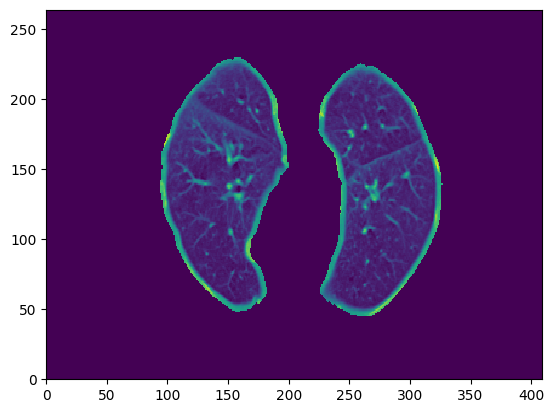

In [36]:
img_new = mask_new * gray
plt.pcolormesh(img_new)

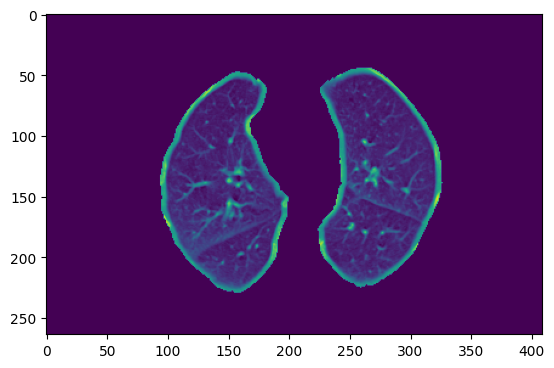

In [39]:


plt.imshow(img_new)

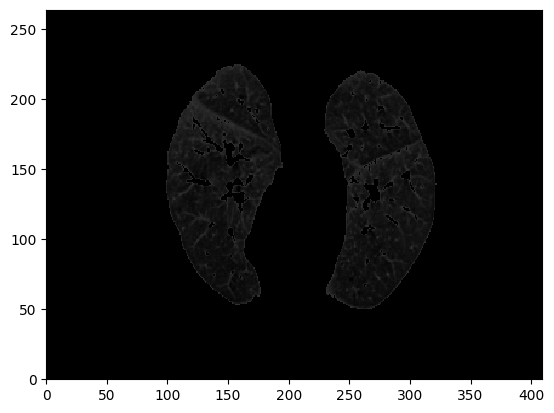

In [64]:
mask_combined = np.zeros_like(image)

for channel_idx in range(3):
    channel = image[:, :, channel_idx]
    mask_channel = mask_new[:, :]  # Assuming 'mask_new' matches in size

    # Perform element-wise multiplication for each channel
    mask_combined[:, :, channel_idx] = channel * mask_channel

# Now, 'mask_combined' contains the result of the multiplication
# You can plot 'mask_combined' or perform any further operations as needed
plt.pcolormesh(mask_combined)